In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.functional import F
import random
from scratch_model import AutoEncoder
from torch.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import image_all
# from sklearn.manifold import MDS
# import plotly.express as px
# import plotly.graph_objects as go



<h1>0 = Up | 1 = Down | 2 = Left | 3 = Right

In [2]:
train_sas, test_sas = image_all.get_sas_data()  

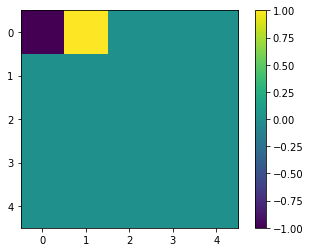

1


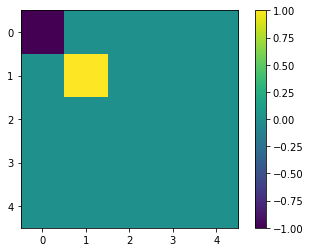

In [3]:
image_all.view_tensor(train_sas[0][0])
print(train_sas[0][1])
image_all.view_tensor(train_sas[0][2])

<h1>Option 1: Action Image to True Image Loss

In [4]:
in_shape = train_sas[0][0].unsqueeze(0).unsqueeze(0).shape
embed_dim = 64 #Seems like optimal one
enc_dropout = 0
dec_dropout = 0.5
model = AutoEncoder(in_shape, embed_dim,dec_drop_out=dec_dropout, enc_drop_out=enc_dropout)
optimizer = Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)


In [5]:
train_divider = 0.04 * len(train_sas)
test_divider = 0.04 * len(test_sas)
for epoch in range(1000):
    model.train()
    avg_total_loss = 0
    avg_init_decode_loss = 0
    avg_next_decode_loss = 0
    for i in random.sample(range(len(train_sas)), len(train_sas)):
        #Prepare Input Data
        input_state, input_action, input_next_state = train_sas[i]
        input_state = input_state.unsqueeze(0).unsqueeze(0)
        input_next_state = input_next_state.unsqueeze(0).unsqueeze(0)
        #Get Model Output
        decoded_init_state, decoded_next_state = model(input_state,input_action,input_next_state,option=1)
        #Calculate Loss
        init_decode_loss = F.mse_loss(decoded_init_state.squeeze(0).squeeze(0), train_sas[i][0])
        next_decode_loss= F.mse_loss(decoded_next_state.squeeze(0).squeeze(0), train_sas[i][2])
        total_loss = init_decode_loss + next_decode_loss
        #Add Loss to Average
        avg_init_decode_loss += init_decode_loss.item()
        avg_next_decode_loss += next_decode_loss.item()
        avg_total_loss += total_loss.item()
        #Backpropagate
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        val_avg_total_loss = 0
        val_avg_init_decode_loss = 0
        val_avg_next_decode_loss = 0    
        for i in random.sample(range(len(test_sas)), len(test_sas)):
            model.eval()
            with torch.no_grad():
                input_state, input_action, input_next_state = test_sas[i]
                input_state = input_state.unsqueeze(0).unsqueeze(0)
                input_next_state = input_next_state.unsqueeze(0).unsqueeze(0)
                decoded_init_state, decoded_next_state = model(input_state,input_action,input_next_state,option=1)
                init_decode_loss = F.mse_loss(decoded_init_state.squeeze(0).squeeze(0), test_sas[i][0])
                next_decode_loss= F.mse_loss(decoded_next_state.squeeze(0).squeeze(0), test_sas[i][2])
                total_loss = init_decode_loss + next_decode_loss
                val_avg_init_decode_loss += init_decode_loss.item()
                val_avg_next_decode_loss += next_decode_loss.item()
                val_avg_total_loss += total_loss.item()
        print(f"{epoch}\nTotal Val Loss: {val_avg_total_loss/test_divider} Decode Val Init Loss: {val_avg_init_decode_loss/test_divider} Decode Val Next Loss: {val_avg_next_decode_loss/test_divider}")
    print(f"Total Loss: {avg_total_loss/train_divider} Decode Init Loss: {avg_init_decode_loss/train_divider} Decode Next Loss: {avg_next_decode_loss/train_divider}")

0
Total Val Loss: 4.0852930139669255 Decode Val Init Loss: 1.9261433358263709 Decode Val Next Loss: 2.1591496781405546
Total Loss: 5.365363312140107 Decode Init Loss: 2.5322786953300236 Decode Next Loss: 2.8330846235156057
Total Loss: 3.665606500953436 Decode Init Loss: 1.4460698643233627 Decode Next Loss: 2.2195366400759666
Total Loss: 3.247267892025411 Decode Init Loss: 1.1377481749048457 Decode Next Loss: 2.109519721241668
Total Loss: 2.965836125984788 Decode Init Loss: 0.9572753565851599 Decode Next Loss: 2.0085607724729924
Total Loss: 2.767458169814199 Decode Init Loss: 0.823816867149435 Decode Next Loss: 1.9436413005925715
Total Loss: 2.6302878273651005 Decode Init Loss: 0.7643325025681407 Decode Next Loss: 1.8659553237725048
Total Loss: 2.4673667792230844 Decode Init Loss: 0.6807378612225875 Decode Next Loss: 1.7866289170924574
Total Loss: 2.367217304557562 Decode Init Loss: 0.6543751199962571 Decode Next Loss: 1.7128421848174185
Total Loss: 2.2692413366399706 Decode Init Loss: 

KeyboardInterrupt: 

In [6]:
#find good example of agent in the middle. Plug in each action and view decoded tensor. Also check with valid data
train_sas[100] # good example 
test_init_state = train_sas[100][0].unsqueeze(0).unsqueeze(0)
test_next_state = train_sas[100][2].unsqueeze(0).unsqueeze(0)

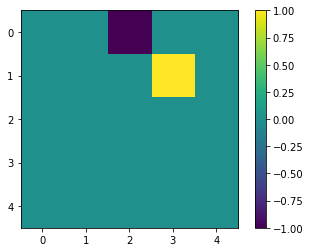

In [7]:
image_all.view_tensor(train_sas[100][0])

In [21]:
action_name_func = lambda x: "Up" if x == 0 else "Down" if x == 1 else "Left" if x == 2 else "Right" if x == 3 else "No Action"

Decoded Tensor


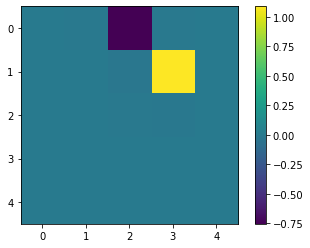

Action: Up


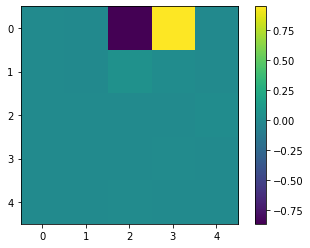

Action: Down


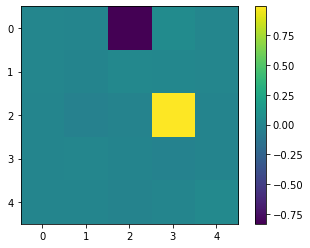

Action: Left


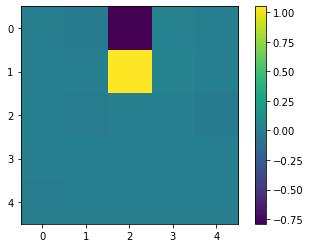

Action: Right


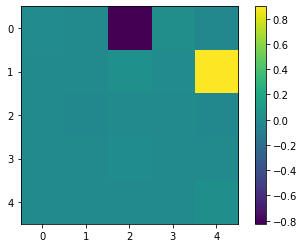

In [23]:
model.eval()
with torch.no_grad():
    decoded_init_state_0, decoded_next_state_0 = model(test_init_state,0,test_next_state,option=1)
    decoded_init_state_1, decoded_next_state_1 = model(test_init_state,1,test_next_state,option=1)
    decoded_init_state_2, decoded_next_state_2 = model(test_init_state,2,test_next_state,option=1)
    decoded_init_state_3, decoded_next_state_3 = model(test_init_state,3,test_next_state,option=1)
#Decoded Tensor
print('Decoded Tensor')
image_all.view_tensor(decoded_init_state_0.squeeze(0).squeeze(0))
for decoded_state, a in zip([decoded_next_state_0,decoded_next_state_1,decoded_next_state_2,decoded_next_state_3],['Up','Down','Left','Right']):
    print('Action:',a)
    image_all.view_tensor(decoded_state.squeeze(0).squeeze(0))


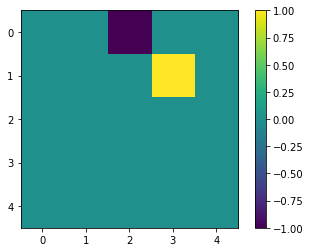

Up


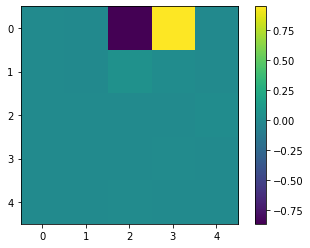

Down


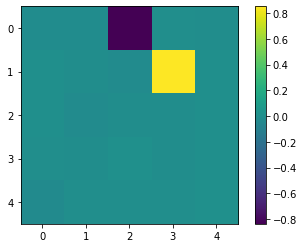

Right


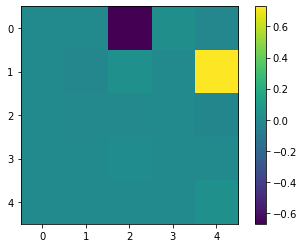

Up


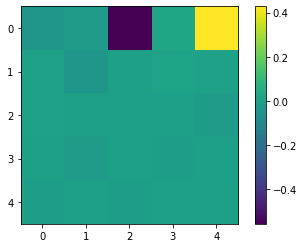

Left


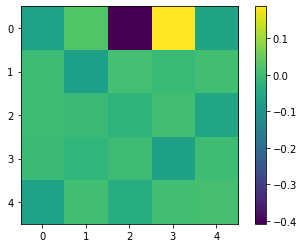

Up


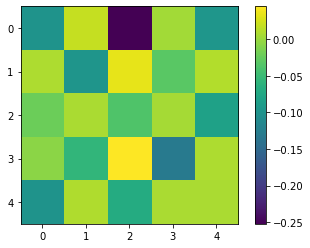

Up


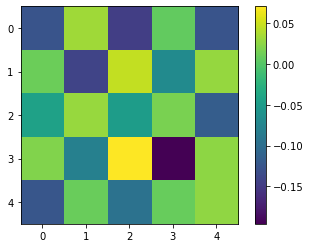

Up


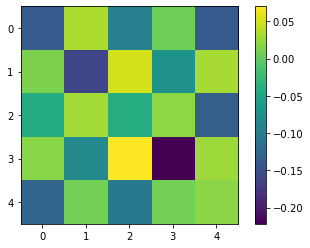

Up


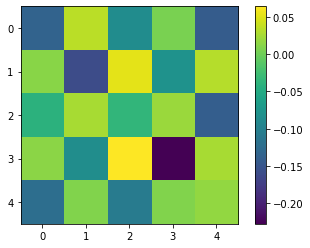

Up


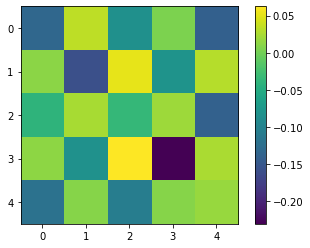

Up


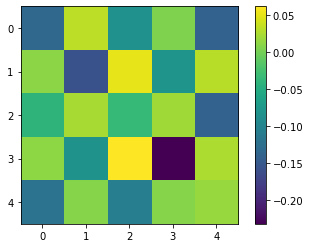

Down


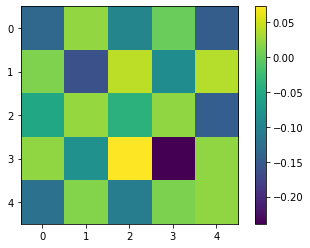

Left


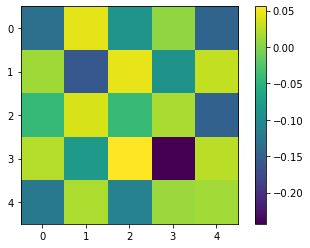

Right


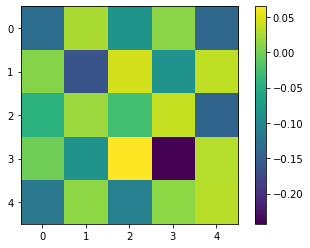

Left


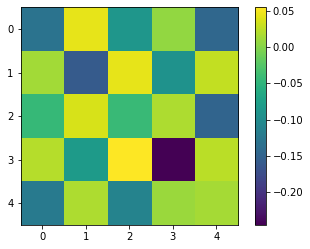

No Action


In [24]:
test_state = train_sas[100][0].unsqueeze(0).unsqueeze(0)
while True:
    image_all.view_tensor(test_state.squeeze(0).squeeze(0))
    action = int(input('Enter Action: '))
    print(action_name_func(action))
    if action > 4:
        break
    _, next_state = model(test_state,action,test_state,option=1)
    test_state = next_state.detach()